In [3]:
# Uncomment and run the commands below if imports fail
!pip install jovian --upgrade --quiet
!conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cpuonly
    - numpy
    - pandas
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py37hc8dfbb8_0         151 KB  conda-forge
    numpy-1.18.5               |   py37h8960a57_0         5.1 MB  conda-forge
    pandas-1.0.5               |   py37h0da4684_0        10.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        15.5 MB

The following NEW packages will be INSTALLED:

  cpuonly            pytorch/noarch::cpuonly-1.0-0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5.2-hecda079_0 --> 2020.6.20-hecda079_0
  certi

In [4]:
import jovian
import torch
import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

<IPython.core.display.Javascript object>

In [5]:
# Project name used for jovian.commit
project_name = 'cats-vs-dogs-feedfwd'

# Directories
test_dir = "../input/dogs-cats-images/dog vs cat/dataset/test_set"
train_dir = "../input/dogs-cats-images/dog vs cat/dataset/training_set"

# Hyperparmeters
batch_size = 32
learning_rate = 0.001

# Other constants
input_size = 64*64*3
output_size = 2

In [7]:
train_dir_cats = train_dir + '/cats'
train_dir_dogs = train_dir + '/dogs'
test_dir_cats = test_dir + '/cats'
test_dir_dogs = test_dir + '/dogs'

In [10]:
cats = os.listdir(train_dir_cats)
print('No. of training examples for cats:', len(cats))
print(cats[:5])

No. of training examples for cats: 4000
['cat.3203.jpg', 'cat.3124.jpg', 'cat.286.jpg', 'cat.1628.jpg', 'cat.3005.jpg']


In [11]:
dogs = os.listdir(train_dir_dogs)
print('No. of training examples for dogs:', len(dogs))
print(dogs[:5])

No. of training examples for dogs: 4000
['dog.3297.jpg', 'dog.462.jpg', 'dog.3380.jpg', 'dog.3403.jpg', 'dog.2399.jpg']


In [12]:
cats = os.listdir(test_dir_cats)
print('No. of testing examples for cats:', len(cats))
print(cats[:5])

No. of testing examples for cats: 1000
['cat.4133.jpg', 'cat.4253.jpg', 'cat.4998.jpg', 'cat.4657.jpg', 'cat.4989.jpg']


In [13]:
dogs = os.listdir(test_dir_dogs)
print('No. of testing examples for dogs:', len(dogs))
print(dogs[:5])

No. of testing examples for dogs: 1000
['dog.4095.jpg', 'dog.4539.jpg', 'dog.4268.jpg', 'dog.4534.jpg', 'dog.4349.jpg']


In [14]:
transformation = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor()])

train_dataset = ImageFolder(train_dir, transform=transformation)
test_dataset = ImageFolder(test_dir, transform=transformation)

Shape of Image: torch.Size([3, 64, 64]) Label: cats (0)


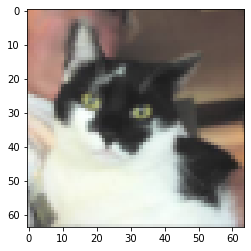

In [15]:
img, label = train_dataset[3999]
print("Shape of Image:", img.shape, "Label:", train_dataset.classes[label] + f" ({label})")
plt.imshow(img.permute((1, 2, 0)))

Shape of Image: torch.Size([3, 64, 64]) Label: dogs (1)


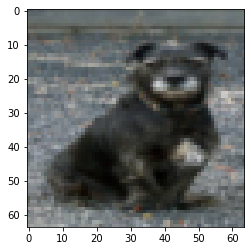

In [16]:
img, label = train_dataset[6000]
print("Shape of Image:", img.shape, "Label:", train_dataset.classes[label] + f" ({label})")
plt.imshow(img.permute((1, 2, 0)))

In [17]:
train_ds, val_ds = random_split(train_dataset, [7000, 1000])
test_ds = random_split(test_dataset, [2000])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

images.shape: torch.Size([32, 3, 64, 64])


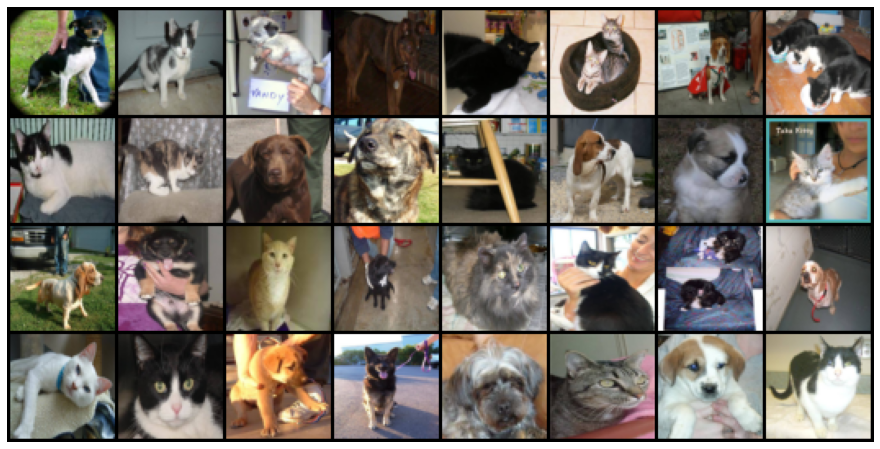

In [13]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [21]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()
device

device(type='cpu')

In [19]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [22]:
class CatsVsDogModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 3072)
        self.linear2 = nn.Linear(3072, 10)
#         self.linear3 = nn.Linear(768, 192)
#         self.linear4 = nn.Linear(192, 48)
#         self.linear5 = nn.Linear(48, 12)
#         self.linear6 = nn.Linear(12, 6)
        self.linear3 = nn.Linear(10, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        
        out = self.linear2(out)
        out = F.relu(out)
        
        out = self.linear3(out)
#         out = F.relu(out)
        
#         out = self.linear4(out)
#         out = F.relu(out)
        
#         out = self.linear5(out)
#         out = F.relu(out)
        
#         out = self.linear6(out)
#         out = F.relu(out)
        
#         out = self.linear7(out)
        
        return out
    
model = to_device(CatsVsDogModel(), device)

In [20]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.7334276437759399, 'val_acc': 0.5029296875}]

In [21]:
epochs_list = [100, 75, 50, 25]
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]

In [ ]:
history += fit(epochs_list[0], learning_rates[0], model, train_loader, val_loader)

Epoch [0], val_loss: 0.6739, val_acc: 0.5801
Epoch [1], val_loss: 0.6665, val_acc: 0.5873
Epoch [2], val_loss: 0.6598, val_acc: 0.6172
Epoch [3], val_loss: 0.6560, val_acc: 0.6039
Epoch [4], val_loss: 0.6581, val_acc: 0.5869
Epoch [5], val_loss: 0.6492, val_acc: 0.6340
Epoch [6], val_loss: 0.6484, val_acc: 0.6195
Epoch [7], val_loss: 0.6684, val_acc: 0.5699
Epoch [8], val_loss: 0.6679, val_acc: 0.5920
Epoch [9], val_loss: 0.6540, val_acc: 0.6031
Epoch [10], val_loss: 0.6324, val_acc: 0.6553
Epoch [11], val_loss: 0.6442, val_acc: 0.6303
Epoch [12], val_loss: 0.6370, val_acc: 0.6402
Epoch [13], val_loss: 0.6588, val_acc: 0.5924
Epoch [14], val_loss: 0.6337, val_acc: 0.6455
Epoch [15], val_loss: 0.6296, val_acc: 0.6404
Epoch [17], val_loss: 0.6368, val_acc: 0.6219
Epoch [18], val_loss: 0.6411, val_acc: 0.6244
Epoch [19], val_loss: 0.6314, val_acc: 0.6463
Epoch [20], val_loss: 0.6803, val_acc: 0.5912
Epoch [21], val_loss: 0.6489, val_acc: 0.6008
Epoch [22], val_loss: 0.6245, val_acc: 0.642

In [ ]:
history += fit(epochs_list[1], learning_rates[1], model, train_loader, val_loader)

In [ ]:
history += fit(epochs_list[2], learning_rates[2], model, train_loader, val_loader)

In [ ]:
history += fit(epochs_list[3], learning_rates[3], model, train_loader, val_loader)

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
final_test_eval = evaluate(model, test_loader)
final_test_eval

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
img, label = test_ds[500]
plt.imshow(img.permute((1, 2, 0)))
print('Label:', label, ', Predicted:', predict_image(img, model))
# print("Shape of Image:", img.shape, "Label:", train_dataset.classes[label] + f" ({label})")

In [ ]:
incorrect_count = 0

for data in test_ds:
    img, label = data
    print('Label:', label, ', Predicted:', predict_image(img, model))
    if (label != predict_image(img, model)):
        incorrect_count += 1

In [ ]:
torch.save(model.state_dict(), 'cats-vs-dogs-feedfwd.pth')
# jovian.log_metrics(val_acc = history[-1]['val_acc'], val_loss = history[-1]['val_loss'], incorrect_predictions = incorrect_count)
# jovian.log_hyperparams(lr = learning_rates, epochs = epochs_list, batch_size = batch_size)
jovian.commit(project='cats-vs-dogs-feedfwd', outputs=['cats-vs-dogs-feedfwd.pth'], environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/pahuja-gor/cats-vs-dogs-feedfwd


<IPython.core.display.Javascript object>